<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tooth_CNN

# 모듈 import

In [1]:
import numpy as np
import pandas as pd
import keras, os, math
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import notebook
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib 
from tensorflow.keras import datasets, layers, models

In [2]:
# tqdm 모듈이 없을시 이부분 실행
# !pip install tqdm
# !pip install tqdm --upgrade

# GPU 작동 방법

In [3]:
# Ture가 나와야 GPU가 작동 되는 중 !
device_lib.list_local_devices() 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 파라미터 설정

In [4]:
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
epoch = 100                                  # epoch 횟수

# Test Data Setting

In [5]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./test"
test_file = os.listdir(path)

# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in test_file:
  test_file.remove('.ipynb_checkpoints')
  
print(test_file) # 경로 내에 모든 파일 출력 ['sino_wmetal.txt'] 

['sino_wmetal.txt']


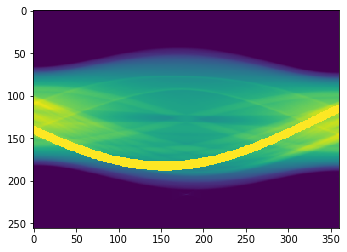

In [6]:
df = pd.read_table('./test/' + test_file[0], sep = ',', header = None) # Test Data 불러오기

plt.imshow(df); # 테스트 이미지 

(256, 380)

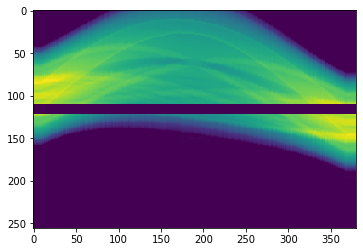

In [7]:
### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
mask_value = 200 # 마스크에 설정 된 값
mask_list = [] # 마스크 리스트 만들기

# mask_value에 맞는 부위 mask_list에 추가
for i in range(360):
  temp = []
  for i, k in zip(df.iloc[:, i]== mask_value, df.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0 # 예측 범위 변수
padding = 0 # 일자로 만들기 위한 마스크 위, 아래를 채울 패딩 추가
metal_line = [] # mask_list를 따라 한줄씩 선 따기
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  # padding의 크기 = 마스크의 크기 / 2
  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------

# 데이터 전처리
for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index) + 1]
y_shape = y_test_range[1] - y_test_range[0]

df.iloc[y_test_range[0] : y_test_range[1], :] = 0
df = df / math.ceil(df.max().max())

df_temp_left = pd.DataFrame()
df_temp_right = pd.DataFrame()
for i in range(int(X_shape[1]/2)):
    df_temp_left[i] = df[0]
    df_temp_right[i] = df[359]

df_left = pd.concat([df_temp_left, df], axis = 1)
df = pd.concat([df_left, df_temp_right], axis = 1)

plt.imshow(df)

df.shape

In [8]:
X_test_org, y_test_org = [], [] # X는 입력 변수, y는 출력 변수

# Test Data Cutting
for i in range(df.shape[1] - X_shape[1] + 1):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_test_org, y_test_org = np.array(X_test_org), np.array(y_test_org) # numpy 형태로 변형하고 reshape

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_test, y_test = X_test_org.reshape(((df.shape[1]-X_shape[1] + 1), X_shape[0], X_shape[1], 1)), y_test_org
print('X_test shape : {}, y_test shape : {}'.format(X_test.shape, y_test.shape))

X_test shape : (360, 20, 21, 1), y_test shape : (360, 12)


# Training Data Setting

In [9]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./train"
file_lst = os.listdir(path)
file_lst.sort()
# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in file_lst:
  file_lst.remove('.ipynb_checkpoints')
# 경로 내에 모든 파일 출력
print(file_lst) # ['test1.text','test2.text','test3.text','.ipynb_checkpoints','test4.text','test.ipynb','test5.text']

# 경로 내에 각각의 파일을 출력
for file in file_lst:
    filepath = path + '/' + file
    print(file)

['sino_1.txt', 'sino_2.txt', 'sino_3.txt', 'sino_4.txt', 'sino_5.txt', 'sino_6.txt', 'sino_7.txt', 'sino_8.txt']
sino_1.txt
sino_2.txt
sino_3.txt
sino_4.txt
sino_5.txt
sino_6.txt
sino_7.txt
sino_8.txt


In [10]:
# 이미지 shift 시키는 과정.
for num, file in zip(range(len(file_lst)), file_lst): 
    globals()['df{}'.format(num)] = pd.read_table(path + '/' + file, sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

# 이미지 양쪽 열 10개씩 늘리는 과정.
for num in range(len(file_lst)):
    df_temp_left = pd.DataFrame()
    df_temp_right = pd.DataFrame()
    for i in range(int(X_shape[1]/2)):
        df_temp_left[i] = globals()['df{}'.format(num)][0]
        df_temp_right[i] = globals()['df{}'.format(num)][359]

    df_left = pd.concat([df_temp_left, globals()['df{}'.format(num)]], axis = 1)
    globals()['df{}'.format(num)] = pd.concat([df_left, df_temp_right], axis = 1)

아래 셀 런타임 오래 걸림

In [11]:
X_train_org, y_train_org = [], [] # X는 입력 변수, y는 출력 변수

# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in notebook.tqdm(range(len(file_lst)), desc='File Count'):
    for i in notebook.tqdm(range(globals()['df{}'.format(num)].shape[1] - X_shape[1] + 1), desc='File Count'):          # i, 열, 1
        for j in range(globals()['df{}'.format(num)].shape[0] - X_shape[0] - y_shape):                         # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

X_train_org, y_train_org = np.array(X_train_org), np.array(y_train_org) # reshape 하기위해 numpy 형태로 변형

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_train = X_train_org.reshape((len(file_lst)*(df.shape[1]-X_shape[1] + 1)*(df.shape[0]-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
y_train = y_train_org
print('X_train shape : {}, y_train shape : {}'.format(X_train.shape, y_train.shape))

File Count:   0%|          | 0/8 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

X_train shape : (645120, 20, 21, 1), y_train shape : (645120, 12)


In [12]:
len(file_lst), (df.shape[1]-X_shape[1] + 1), (df.shape[0]-X_shape[0]-y_shape) ,20 , 21 , 1

(8, 360, 224, 20, 21, 1)

In [13]:
X_test_org.shape

(360, 20, 21)

# 모델

In [14]:
# model 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1), padding = 'same'))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 모델 검증
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델 저장
mc = keras.callbacks.ModelCheckpoint('./save_model/best_model_shape{}.h5'.format(y_shape), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

gpu가 없으면 학습이 오래 걸립니다.

In [15]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

Epoch 1/100
20148/20160 [============================>.] - ETA: 0s - loss: 9.7630e-04 - accuracy: 0.3819
Epoch 00001: val_accuracy improved from -inf to 0.54444, saving model to ./save_model/best_model_shape12.h5
20160/20160 [==============================] - 30s 1ms/step - loss: 9.7600e-04 - accuracy: 0.3820 - val_loss: 0.4364 - val_accuracy: 0.5444
Epoch 2/100
20139/20160 [============================>.] - ETA: 0s - loss: 4.3204e-04 - accuracy: 0.4276
Epoch 00002: val_accuracy improved from 0.54444 to 0.77778, saving model to ./save_model/best_model_shape12.h5
20160/20160 [==============================] - 28s 1ms/step - loss: 4.3212e-04 - accuracy: 0.4274 - val_loss: 0.4747 - val_accuracy: 0.7778
Epoch 3/100
20131/20160 [============================>.] - ETA: 0s - loss: 3.4524e-04 - accuracy: 0.4289
Epoch 00003: val_accuracy did not improve from 0.77778
20160/20160 [==============================] - 27s 1ms/step - loss: 3.4517e-04 - accuracy: 0.4288 - val_loss: 0.4620 - val_accuracy

12/12 [==============================] - 0s 1ms/step - loss: 0.4747 - accuracy: 0.7778

 테스트 정확도: 0.7778


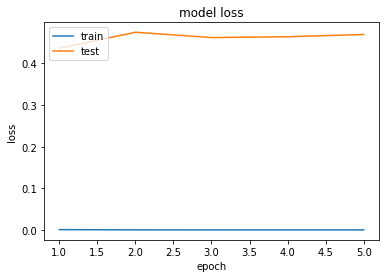

In [16]:
# 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가
loaded_model = load_model('./save_model/best_model_shape{}.h5'.format(y_shape))
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실을 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

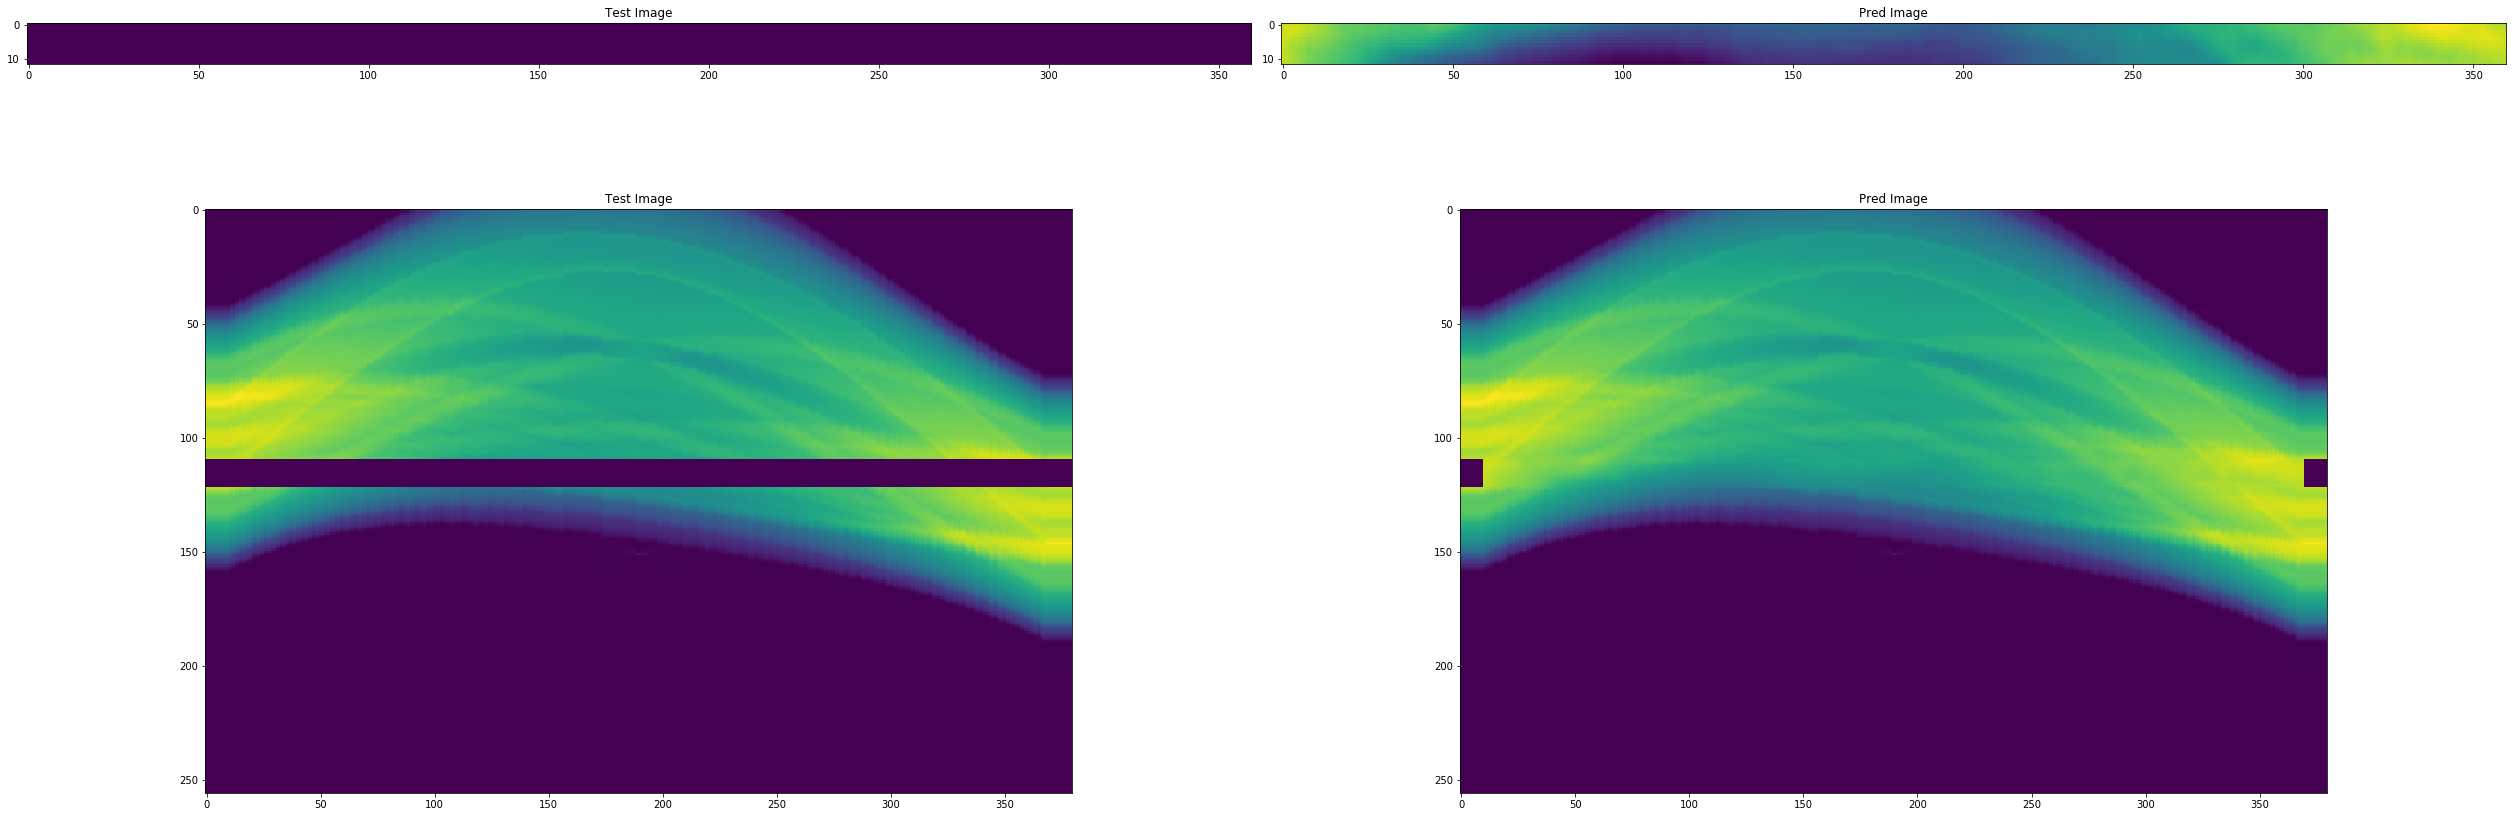

In [17]:
# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

예측 결과 원본 데이터에 덮어쓰기

예측 이미지 형태 : (256, 360), 예측 범위 : 12칸


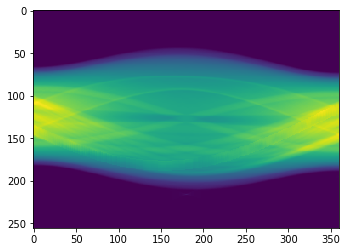

In [18]:
df_pred = pd.read_table('./test/' + test_file[0], sep = ',', header = None) # 원본 Test Data 불러오기
for i, j, k in zip(df_pred.columns, metal_shift, metal_line):
    df_pred = df_pred / math.ceil(df_pred.max().max())
    df_pred.iloc[k - 1 - padding : k + padding + 1, i] = pred[i]
        
plt.imshow(df_pred)
print('예측 이미지 형태 : {}, 예측 범위 : {}칸'.format(df_pred.shape, y_shape))

In [19]:
# 테스트 정확도 4자리 수로 저장
test_acc = int(round(loaded_model.evaluate(X_test, y_test)[1], 4)*(10**4))
print('test 정확도 : {}%'.format(test_acc*(10**-2)))

# mat 저장
import scipy.io as sio
sio.savemat('./save_img/one_metal_{}.mat'.format(test_acc), {'values' : df_pred.values})

# txt 저장
df_pred.to_csv('./save_img/one_metal_{}.txt'.format(test_acc))

12/12 [==============================] - 0s 1ms/step - loss: 0.4747 - accuracy: 0.7778
test 정확도 : 77.78%


# Metal Add

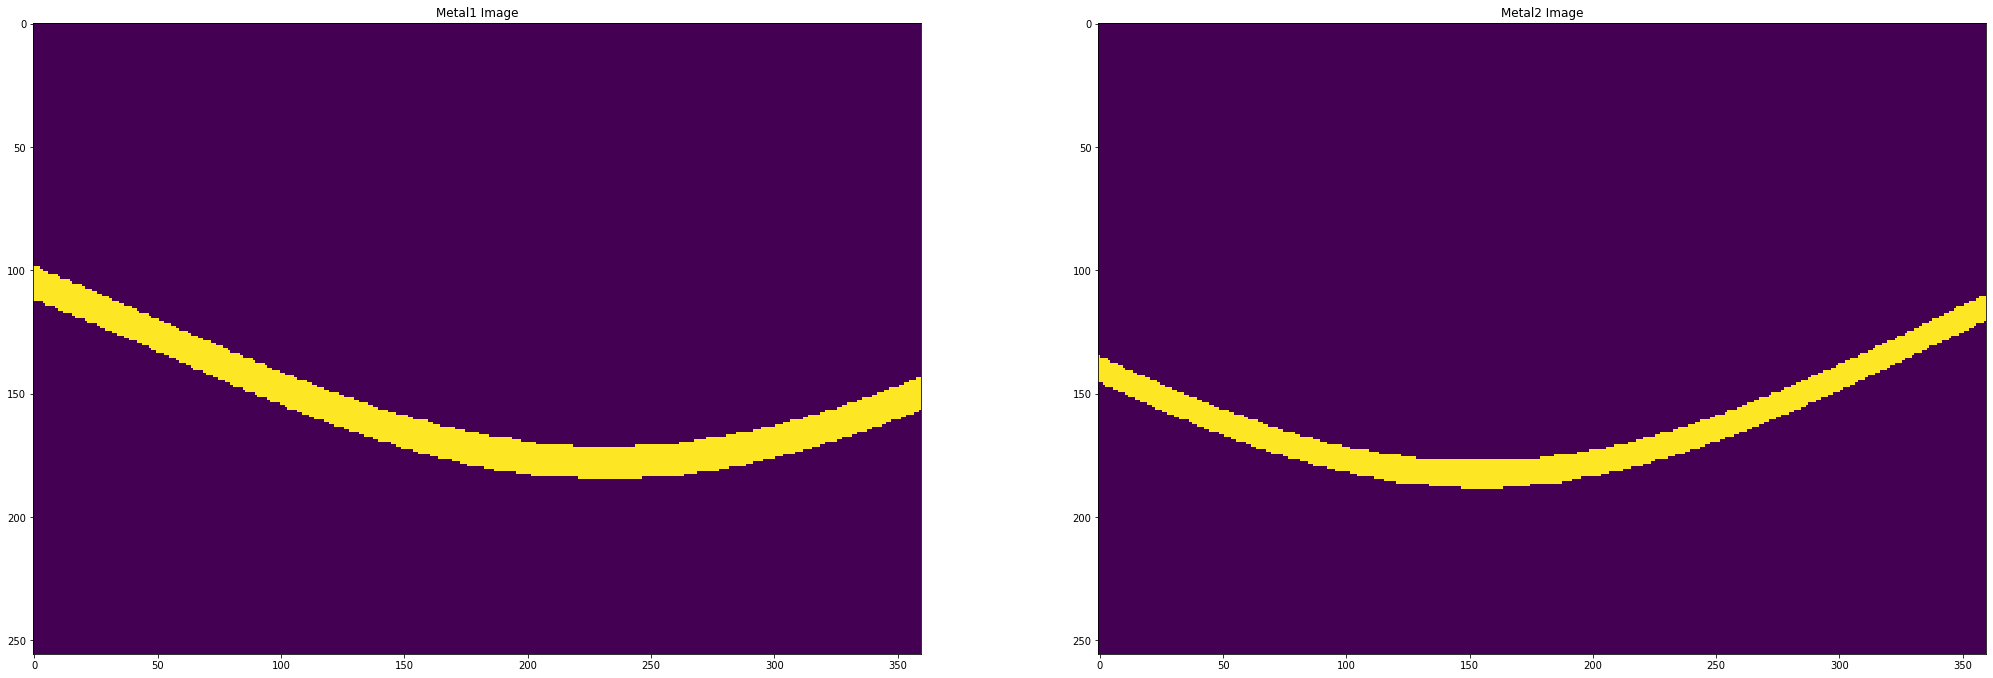

In [20]:
df_metal1 = pd.read_table('./metal/metalsino_2.txt',sep = ',', header = None)
df_metal2 = pd.read_table('./metal/metalsino_1.txt',sep = ',', header = None)

figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (35, 15))
axes[0].set_title('Metal1 Image')
axes[0].imshow(df_metal1)
axes[1].set_title('Metal2 Image')
axes[1].imshow(df_metal2);

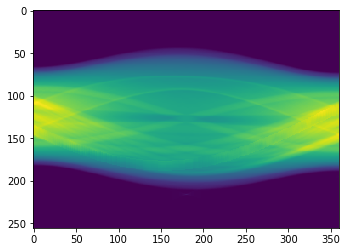

In [21]:
df=pd.DataFrame([i for i in df_pred.values])
plt.imshow(df)

# Metal1 Test Data Setting

In [22]:
### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
# 예측 했던 데이터 위에 metal 추가
df=pd.DataFrame([i for i in df_pred.values])

mask_value = 200
mask_list = []

# 마스킹 값에 해당하는 부분 예측
for i in range(360):
  temp = []
  for i, k in zip(df_metal1.iloc[:, i]== mask_value, df_metal1.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0
padding = 0
metal_line = []
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------

(256, 380)

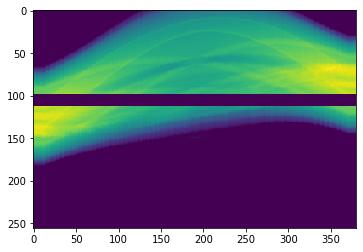

In [23]:
# 마스킹 부분 일자로 쉬프트
for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index) + 1]
y_shape = y_test_range[1] - y_test_range[0]

df.iloc[y_test_range[0] : y_test_range[1], :] = 0

# 양쪽 모두 열 (X_shape[1]/2) 개 추가
df_temp_left = pd.DataFrame()
df_temp_right = pd.DataFrame()
for i in range(int(X_shape[1]/2)):
    df_temp_left[i] = df[0]
    df_temp_right[i] = df[359]

df_left = pd.concat([df_temp_left, df], axis = 1)
df = pd.concat([df_left, df_temp_right], axis = 1)

plt.imshow(df)

df.shape

In [24]:
X_test_org, y_test_org = [], [] # X는 입력 변수, y는 출력 변수

# Test Data Cutting
for i in range(df.shape[1] - X_shape[1] + 1):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_test_org, y_test_org = np.array(X_test_org), np.array(y_test_org) # numpy 형태로 변형하고 reshape

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_test, y_test = X_test_org.reshape(((df.shape[1]-X_shape[1] + 1), X_shape[0], X_shape[1], 1)), y_test_org
print('X_test shape : {}, y_test shape : {}'.format(X_test.shape, y_test.shape))

X_test shape : (360, 20, 21, 1), y_test shape : (360, 14)


# Metal1 Training Data Setting

In [25]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./train"
file_lst = os.listdir(path)
file_lst.sort()
# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in file_lst:
  file_lst.remove('.ipynb_checkpoints')
# 경로 내에 모든 파일 출력
print(file_lst) # ['test1.text','test2.text','test3.text','.ipynb_checkpoints','test4.text','test.ipynb','test5.text']

# 경로 내에 각각의 파일을 출력
for file in file_lst:
    filepath = path + '/' + file
    print(file)

# 이미지 shift 시키는 과정.
for num, file in zip(range(len(file_lst)), file_lst): 
    globals()['df{}'.format(num)] = pd.read_table(path + '/' + file, sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

# 이미지 양쪽 열 10개씩 늘리는 과정.
for num in range(len(file_lst)):
    df_temp_left = pd.DataFrame()
    df_temp_right = pd.DataFrame()
    for i in range(int(X_shape[1]/2)):
        df_temp_left[i] = globals()['df{}'.format(num)][0]
        df_temp_right[i] = globals()['df{}'.format(num)][359]

    df_left = pd.concat([df_temp_left, globals()['df{}'.format(num)]], axis = 1)
    globals()['df{}'.format(num)] = pd.concat([df_left, df_temp_right], axis = 1)

['sino_1.txt', 'sino_2.txt', 'sino_3.txt', 'sino_4.txt', 'sino_5.txt', 'sino_6.txt', 'sino_7.txt', 'sino_8.txt']
sino_1.txt
sino_2.txt
sino_3.txt
sino_4.txt
sino_5.txt
sino_6.txt
sino_7.txt
sino_8.txt


아래 셀 런타임 오래 걸림

In [26]:
X_train_org, y_train_org = [], [] # X는 입력 변수, y는 출력 변수

# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in notebook.tqdm(range(len(file_lst)), desc='File Count'):
    for i in notebook.tqdm(range(globals()['df{}'.format(num)].shape[1] - X_shape[1] + 1), desc='File Count'):          # i, 열, 1
        for j in range(globals()['df{}'.format(num)].shape[0] - X_shape[0] - y_shape):                         # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

X_train_org, y_train_org = np.array(X_train_org), np.array(y_train_org) # reshape 하기위해 numpy 형태로 변형

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_train = X_train_org.reshape((len(file_lst)*(df.shape[1]-X_shape[1] + 1)*(df.shape[0]-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
y_train = y_train_org
print('X_train shape : {}, y_train shape : {}'.format(X_train.shape, y_train.shape))

len(file_lst), (df.shape[1]-X_shape[1] + 1), (df.shape[0]-X_shape[0]-y_shape) ,20 , 21 , 1

X_test_org.shape

File Count:   0%|          | 0/8 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

X_train shape : (639360, 20, 21, 1), y_train shape : (639360, 14)


(360, 20, 21)

# Metal1 모델
gpu가 없으면 학습이 오래 걸립니다.

In [27]:
# y_shape에 해당하는 모델이 없으면 실행
# model 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1), padding = 'same'))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 모델 검증
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델 저장
mc = keras.callbacks.ModelCheckpoint('./save_model/best_model_shape{}.h5'.format(y_shape), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

# 모델 훈련
history = model.fit(X_train, y_train, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

# 학습된 모델 불러오기

In [28]:
# 저장된 모델이 있을때 주석 해제 후 실행
# 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가
loaded_model = load_model('./save_model/best_model_shape{}.h5'.format(y_shape))
loaded_model.summary()
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# model 구성
loaded_model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

# 불러온 학습된 모델 추가 학습 시키려면 사용
gpu가 없으면 학습이 느립니다.

In [29]:
# 훈련된 모델에 추가 학습 하려면 사용, Matal1 Train Data Setting 부분 실행 해야 함.
history = loaded_model.fit(X_train, y_train, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = loaded_model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print('테스트 정확도 : %.4f' %test_acc)   # 정확도

Epoch 1/100
19959/19980 [============================>.] - ETA: 0s - loss: 5.5896e-04 - accuracy: 0.4292
Epoch 00001: val_accuracy improved from 0.68056 to 0.76944, saving model to ./save_model/best_model_shape14.h5
19980/19980 [==============================] - 27s 1ms/step - loss: 5.5882e-04 - accuracy: 0.4292 - val_loss: 0.4757 - val_accuracy: 0.7694
Epoch 2/100
19961/19980 [============================>.] - ETA: 0s - loss: 4.5811e-04 - accuracy: 0.4226
Epoch 00002: val_accuracy did not improve from 0.76944
19980/19980 [==============================] - 27s 1ms/step - loss: 4.5799e-04 - accuracy: 0.4225 - val_loss: 0.4612 - val_accuracy: 0.6528
Epoch 3/100
19975/19980 [============================>.] - ETA: 0s - loss: 4.1600e-04 - accuracy: 0.4047
Epoch 00003: val_accuracy did not improve from 0.76944
19980/19980 [==============================] - 27s 1ms/step - loss: 4.1595e-04 - accuracy: 0.4047 - val_loss: 0.4683 - val_accuracy: 0.5556
Epoch 4/100
19955/19980 [===================

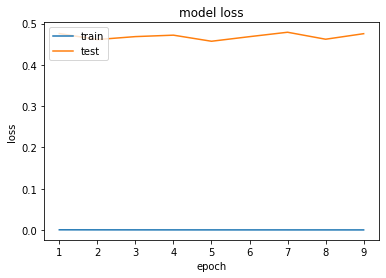

In [30]:
# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실을 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

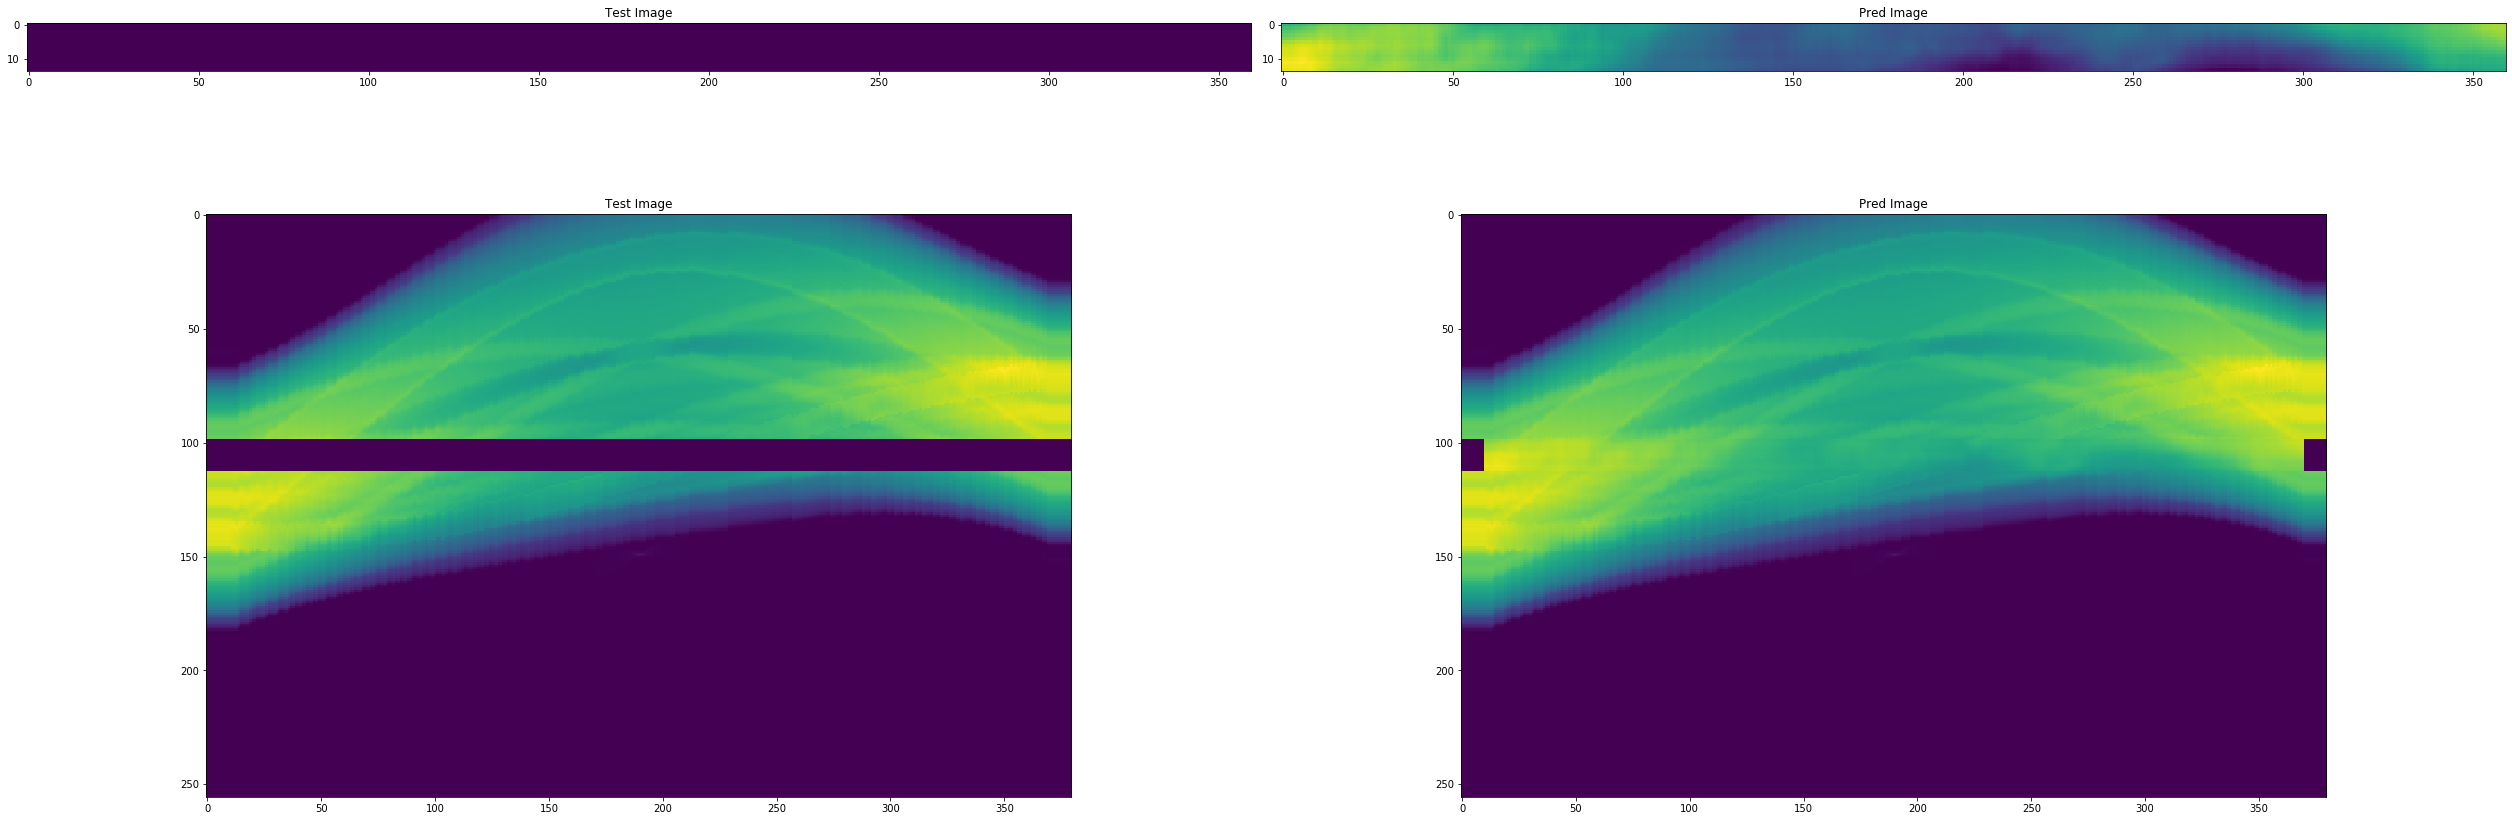

In [31]:
# 모델 예측
pred = loaded_model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

예측 결과 원본 데이터에 덮어쓰기

예측 이미지 형태 : (256, 360), 예측 범위 : 14칸


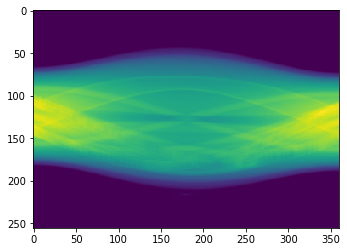

In [32]:
for i, j, k in zip(df_pred.columns, metal_shift, metal_line):
    df_pred = df_pred / math.ceil(df_pred.max().max())
    df_pred.iloc[k - 1 - padding : k + padding + 1, i] = pred[i]
        
plt.imshow(df_pred)
print('예측 이미지 형태 : {}, 예측 범위 : {}칸'.format(df_pred.shape, y_shape))

In [33]:
# 테스트 정확도 4자리 수로 저장
test_acc = int(round(loaded_model.evaluate(X_test, y_test)[1], 4)*(10**4))
print('test 정확도 : {}%'.format(test_acc*(10**-2)))

# mat 저장
import scipy.io as sio
sio.savemat('./save_img/two_metal_{}.mat'.format(test_acc), {'values' : df_pred.values})

# txt 저장
df_pred.to_csv('./save_img/two_metal_{}.txt'.format(test_acc))

12/12 [==============================] - 0s 1ms/step - loss: 0.4754 - accuracy: 0.2472
test 정확도 : 24.72%


# Metal2 Test Data Setting

In [34]:
### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
# 예측 했던 데이터 위에 metal 추가
df=pd.DataFrame([i for i in df_pred.values])

mask_value = 200
mask_list = []

# 마스킹 값에 해당하는 부분 예측
for i in range(360):
  temp = []
  for i, k in zip(df_metal2.iloc[:, i]== mask_value, df_metal2.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0
padding = 0
metal_line = []
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------

(256, 380)

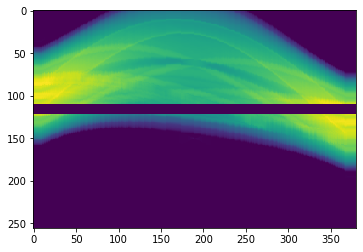

In [35]:
# 마스킹 부분 일자로 쉬프트
for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index) + 1]
y_shape = y_test_range[1] - y_test_range[0]

df.iloc[y_test_range[0] : y_test_range[1], :] = 0

# 양쪽 모두 열 (X_shape[1]/2) 개 추가
df_temp_left = pd.DataFrame()
df_temp_right = pd.DataFrame()
for i in range(int(X_shape[1]/2)):
    df_temp_left[i] = df[0]
    df_temp_right[i] = df[359]

df_left = pd.concat([df_temp_left, df], axis = 1)
df = pd.concat([df_left, df_temp_right], axis = 1)

plt.imshow(df)

df.shape

In [36]:
X_test_org, y_test_org = [], [] # X는 입력 변수, y는 출력 변수

# Test Data Cutting
for i in range(df.shape[1] - X_shape[1] + 1):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_test_org, y_test_org = np.array(X_test_org), np.array(y_test_org) # numpy 형태로 변형하고 reshape

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_test, y_test = X_test_org.reshape(((df.shape[1]-X_shape[1] + 1), X_shape[0], X_shape[1], 1)), y_test_org
print('X_test shape : {}, y_test shape : {}'.format(X_test.shape, y_test.shape))

X_test shape : (360, 20, 21, 1), y_test shape : (360, 12)


# Metal2 Training Data Setting

In [37]:
# 현재 디렉토리 내에서 파일 경로 설정
path = "./train"
file_lst = os.listdir(path)
file_lst.sort()
# 리스트 내 checkpoint가 있으면 제거
if '.ipynb_checkpoints' in file_lst:
  file_lst.remove('.ipynb_checkpoints')
# 경로 내에 모든 파일 출력
print(file_lst) # ['test1.text','test2.text','test3.text','.ipynb_checkpoints','test4.text','test.ipynb','test5.text']

# 경로 내에 각각의 파일을 출력
for file in file_lst:
    filepath = path + '/' + file
    print(file)

# 이미지 shift 시키는 과정.
for num, file in zip(range(len(file_lst)), file_lst): 
    globals()['df{}'.format(num)] = pd.read_table(path + '/' + file, sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

# 이미지 양쪽 열 10개씩 늘리는 과정.
for num in range(len(file_lst)):
    df_temp_left = pd.DataFrame()
    df_temp_right = pd.DataFrame()
    for i in range(int(X_shape[1]/2)):
        df_temp_left[i] = globals()['df{}'.format(num)][0]
        df_temp_right[i] = globals()['df{}'.format(num)][359]

    df_left = pd.concat([df_temp_left, globals()['df{}'.format(num)]], axis = 1)
    globals()['df{}'.format(num)] = pd.concat([df_left, df_temp_right], axis = 1)

['sino_1.txt', 'sino_2.txt', 'sino_3.txt', 'sino_4.txt', 'sino_5.txt', 'sino_6.txt', 'sino_7.txt', 'sino_8.txt']
sino_1.txt
sino_2.txt
sino_3.txt
sino_4.txt
sino_5.txt
sino_6.txt
sino_7.txt
sino_8.txt


아래 셀 런타임 오래 걸림

In [38]:
X_train_org, y_train_org = [], [] # X는 입력 변수, y는 출력 변수

# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in notebook.tqdm(range(len(file_lst)), desc='File Count'):
    for i in notebook.tqdm(range(globals()['df{}'.format(num)].shape[1] - X_shape[1] + 1), desc='File Count'):          # i, 열, 1
        for j in range(globals()['df{}'.format(num)].shape[0] - X_shape[0] - y_shape):                         # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

X_train_org, y_train_org = np.array(X_train_org), np.array(y_train_org) # reshape 하기위해 numpy 형태로 변형

# Conv2D 입력 형태에 맞게 reshape
# RGB 값을 추가 합니다. 흑백으로 설정 하였습니다.
X_train = X_train_org.reshape((len(file_lst)*(df.shape[1]-X_shape[1] + 1)*(df.shape[0]-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
y_train = y_train_org
print('X_train shape : {}, y_train shape : {}'.format(X_train.shape, y_train.shape))

len(file_lst), (df.shape[1]-X_shape[1] + 1), (df.shape[0]-X_shape[0]-y_shape) ,20 , 21 , 1

X_test_org.shape

File Count:   0%|          | 0/8 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

File Count:   0%|          | 0/360 [00:00<?, ?it/s]

X_train shape : (645120, 20, 21, 1), y_train shape : (645120, 12)


(360, 20, 21)

# Metal2 모델
gpu가 없으면 학습이 오래 걸립니다.

In [39]:
# y_shape에 해당하는 모델이 없으면 실행
# model 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1), padding = 'same'))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 모델 검증
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델 저장
mc = keras.callbacks.ModelCheckpoint('./save_model/best_model_shape{}.h5'.format(y_shape), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

# 모델 훈련
history = model.fit(X_train, y_train, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

# 학습된 모델에 추가 트레이닝

In [40]:
# 저장된 모델이 있을때 주석 해제 후 실행
# 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가
loaded_model = load_model('./save_model/best_model_shape{}.h5'.format(y_shape))
loaded_model.summary()
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# model 구성
loaded_model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 20, 21, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

# 학습된 모델 추가 학습 시키려면 사용

In [41]:
# 훈련된 모델에 추가 학습 하려면 사용, Matal2 Train Data Setting 부분 실행 해야 함.
history = loaded_model.fit(X_train, y_train, epochs=epoch, callbacks=[es, mc], validation_data=(X_test, y_test), verbose = 1)

test_loss, test_acc = loaded_model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print('테스트 정확도 : %.4f' %test_acc)   # 정확도

Epoch 1/100
20122/20160 [============================>.] - ETA: 0s - loss: 2.6028e-04 - accuracy: 0.4091
Epoch 00001: val_accuracy did not improve from 0.93889
20160/20160 [==============================] - 26s 1ms/step - loss: 2.6027e-04 - accuracy: 0.4091 - val_loss: 0.4438 - val_accuracy: 0.7889
Epoch 2/100
20132/20160 [============================>.] - ETA: 0s - loss: 2.5104e-04 - accuracy: 0.4087
Epoch 00002: val_accuracy did not improve from 0.93889
20160/20160 [==============================] - 26s 1ms/step - loss: 2.5108e-04 - accuracy: 0.4089 - val_loss: 0.4539 - val_accuracy: 0.8333
Epoch 3/100
20130/20160 [============================>.] - ETA: 0s - loss: 2.4573e-04 - accuracy: 0.4087
Epoch 00003: val_accuracy did not improve from 0.93889
20160/20160 [==============================] - 26s 1ms/step - loss: 2.4571e-04 - accuracy: 0.4087 - val_loss: 0.4481 - val_accuracy: 0.4444
Epoch 4/100
20132/20160 [============================>.] - ETA: 0s - loss: 2.4026e-04 - accuracy: 0.

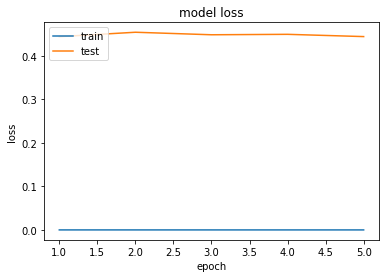

In [42]:
# 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실을 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

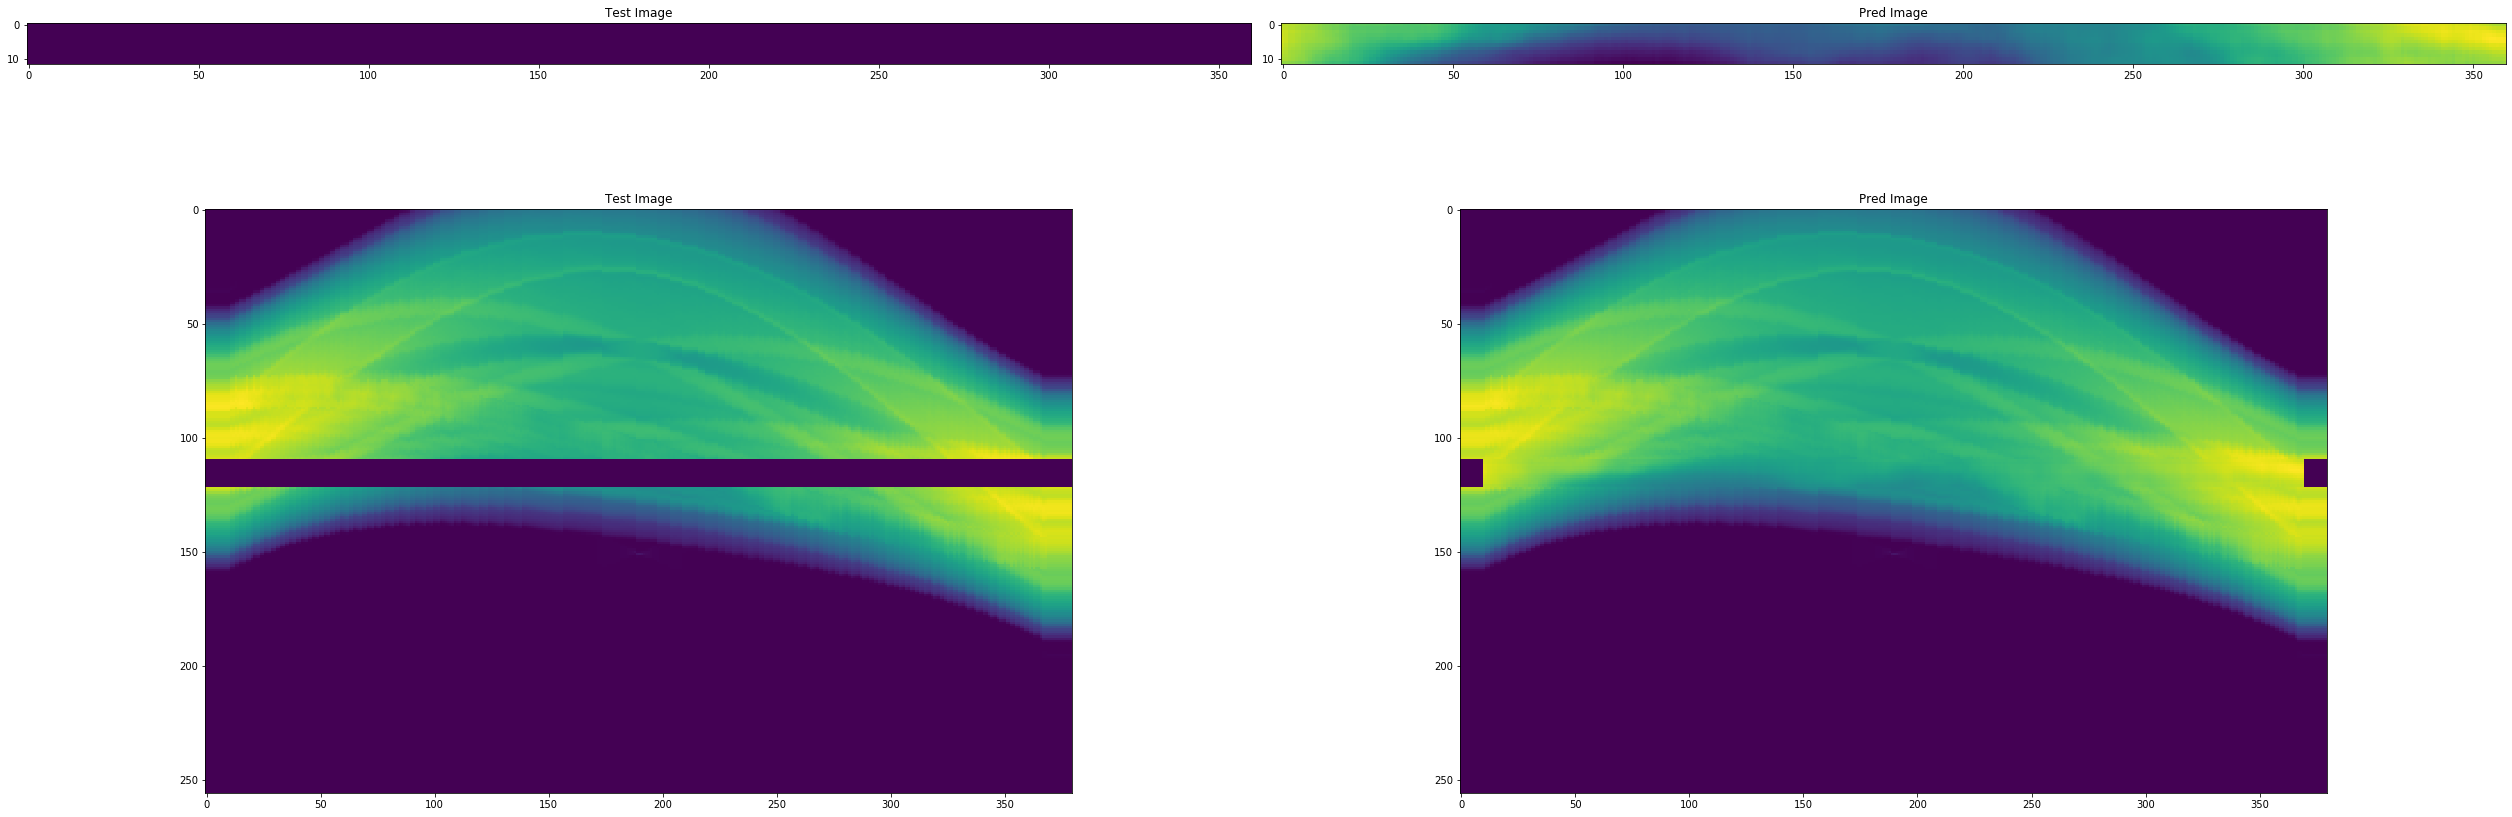

In [43]:
# 모델 예측
pred = loaded_model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

예측 결과 원본 데이터에 덮어쓰기

예측 이미지 형태 : (256, 360), 예측 범위 : 12칸


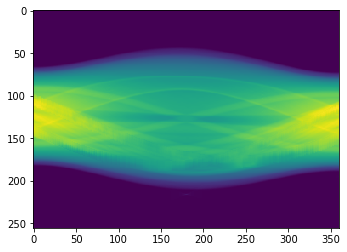

In [44]:
for i, j, k in zip(df_pred.columns, metal_shift, metal_line):
    df_pred = df_pred / math.ceil(df_pred.max().max())
    df_pred.iloc[k - 1 - padding : k + padding + 1, i] = pred[i]
        
plt.imshow(df_pred)
print('예측 이미지 형태 : {}, 예측 범위 : {}칸'.format(df_pred.shape, y_shape))

In [45]:
# 테스트 정확도 4자리 수로 저장
test_acc = int(round(loaded_model.evaluate(X_test, y_test)[1], 4)*(10**4))
print('test 정확도 : {}%'.format(test_acc*(10**-2)))

# mat 저장
import scipy.io as sio
sio.savemat('./save_img/three_metal_{}.mat'.format(test_acc), {'values' : df_pred.values})

# txt 저장
df_pred.to_csv('./save_img/three_metal_{}.txt'.format(test_acc))

12/12 [==============================] - 0s 997us/step - loss: 0.4439 - accuracy: 0.6833
test 정확도 : 68.33%
